# These are the Cartography visuals.

# To Do:
- add snakemake commands instead of explicit paths once main snakefile is updated
- add genetic KDE to full plot (create using the scripts)

# Imports Section 

In [27]:
import altair as alt
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
#from reportlab.graphics import renderPDF
import seaborn as sns
#from svglib.svglib import svg2rlg

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [28]:
try: 
    snakemake.input.tree 
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


# Zika Specific Variables 

In [29]:
try:
    path = snakemake.input.alignment
    dropped_strains = [line.rstrip('\n') for line in open(snakemake.input.dropped_strains,"r")]
    tree_path = snakemake.input.tree
    if snakemake.input.clade_names is not None:
        clades_to_plot = [line.rstrip('\n') for line in open(snakemake.input[len(snakemake.input)-2],"r")]
    f = open(snakemake.input.disease_name, "r")
    virus_name = f.read()
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


In [30]:
#path = "../zika-nextstrain/results/aligned.fasta"
#tree_path = '../auspice/cartography_zika.json'
virus_name = "Zika"
clades_to_plot = None

# Reading in all the data from the scripts

In [31]:
import os

os.getcwd()

'/mnt/c/Work/BedfordProjects/cartography/zika-nextstrain'

In [32]:
node_df = pd.read_csv("results/table.tsv", sep="\t")

In [33]:
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)

In [34]:
similarity_matrix = pd.read_csv("results/distance_matrix.csv", index_col=0)

In [35]:
similarity_matrix.columns = similarity_matrix.index

In [36]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

clades_to_plot undefined


In [37]:
indices_to_drop = similarity_matrix[~similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix[similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix.drop(indices_to_drop.index, axis=1)
similarity_matrix

FrenchPolynesia2014_060114_016  1_0049_PF  \
FrenchPolynesia2014_060114_016                               0         13   
1_0049_PF                                                   13          0   
1_0030_PF                                                   13         13   
1_0035_PF                                                   14         14   
1_0087_PF                                                   11         11   
...                                                        ...        ...   
MEX/2016/mex45                                              21         20   
Bahia15                                                     10          8   
NIC/5847_12B1/2016                                          23         22   
USA/2016/FLUR005                                            27         24   
USA/2016/FLUR001                                            24         21   

                                1_0030_PF  1_0035_PF  1_0087_PF  1_0181_PF  \
FrenchPolynesia2014_060114_016         13         14         11         10   
1_0049_PF                              13         14         11         10   
1_0030_PF                               0         11          8          9   
1_0035_PF                              11          0          7         10   
1_0087_PF                               8          7          0          7   
...                                   ...        ...        ...        ...   
MEX/2016/mex45                         22         24         21         20   
Bahia15                                 9         10          9          8   
NIC/5847_12B1/2016                     24         21         21         21   
USA/2016/FLUR005                       26         25         24         23   
USA/2016/FLUR001                       20         22         19         22   

                                1_0015_PF  H/PF/2013  TS17_2016  1_0199_PF  \
FrenchPolynesia2014_060114_016         13         12         24          8   
1_0049_PF                              13         12         24          8   
1_0030_PF                              12          9         21          8   
1_0035_PF                              13          8         22          9   
1_0087_PF                              10          5         19          6   
...                                   ...        ...        ...        ...   
MEX/2016/mex45                         21         21         28         20   
Bahia15                                 9          7         13          7   
NIC/5847_12B1/2016                     19         21         27         15   
USA/2016/FLUR005                       25         24         28         18   
USA/2016/FLUR001                       22         19         27         13   

                                ...  MEX/2016/mex04  USA/2016/FL029  \
FrenchPolynesia2014_060114_016  ...              25              25   
1_0049_PF                       ...              21              22   
1_0030_PF                       ...              25              25   
1_0035_PF                       ...              24              26   
1_0087_PF                       ...              23              24   
...                             ...             ...             ...   
MEX/2016/mex45                  ...              10              12   
Bahia15                         ...              17              12   
NIC/5847_12B1/2016              ...              10              20   
USA/2016/FLUR005                ...              23               7   
USA/2016/FLUR001                ...              18               8   

                                COL/2016/SU_2293A  MEX/2016/mex38  \
FrenchPolynesia2014_060114_016                 19              19   
1_0049_PF                                      12              18   
1_0030_PF                                      16              21   
1_0035_PF                                      16              25   
1_0087_PF                          

In [38]:
node_df

strain     date  pca1  pca2   mds1   mds2  tsne_x  \
0                    SG_021  2016.70  4.98 -0.16 -46.15  -5.54    8.16   
1                  SI_BKK06  2017.68  2.86 -0.07 -21.59 -11.20   11.87   
2                     BKK07  2017.75  6.89 -0.05 -17.17   4.43   -2.82   
3         Thailand/1610acTw  2016.83  7.03  0.01  -3.10   3.54  -12.08   
4        Thai/KngSG/17_D501  2017.95  6.95  0.01   9.03 -19.16  -13.72   
..                      ...      ...   ...   ...    ...    ...     ...   
669  MEX/43_023_F_V3_O/2016  2016.82 -1.92 -1.83  -9.34  -0.18   12.89   
670  MEX/43_023_F_V0_O/2016  2016.80 -1.93 -1.49  -3.90  -5.85   12.89   
671       mex07/Mexico/2016  2016.59 -2.02 -1.87  -6.18   0.97   10.20   
672          MEX/2016/mex35  2016.52 -2.07 -2.03  -4.56  -0.73   10.38   
673          MEX/2016/mex38  2016.58 -1.78 -0.88  -2.19  -1.48   10.23   

     tsne_y  umap_x  umap_y clade_membership    y clade_membership_color  
0     -1.20   47.19  -18.03       unassigned    1             unassigned  
1     -9.35   47.29  -17.73       unassigned    2             unassigned  
2      8.23   47.49  -18.25               c2    3                     c2  
3     28.04   47.64  -18.00               c2    4                     c2  
4     24.48   47.50  -17.89               c2    5                     c2  
..      ...     ...     ...              ...  ...                    ...  
669  -19.06    6.43    8.52               c4  670                     c4  
670  -19.06    4.94    8.89               c4  671                     c4  
671  -17.19    5.88    9.31               c4  672                     c4  
672  -16.47    6.51    8.92               c4  673                     c4  
673  -16.10   -0.25    5.44               c4  674                     c4  

[674 rows x 13 columns]

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [39]:
#principalDf = pd.read_csv(snakemake.input.pca)
principalDf = pd.read_csv("results/embed_pca.csv", index_col=0)

In [40]:
#explained_variance_df = pd.read_csv(snakemake.input.pca + "explained_variance")
explained_variance_df = pd.read_csv("results/explained_variance_pca.csv")
explained_variance_df

explained variance  principal components
0              0.3303                     0
1              0.0668                     1
2              0.0582                     2
3              0.0410                     3
4              0.0278                     4
5              0.0181                     5
6              0.0137                     6
7              0.0127                     7
8              0.0100                     8
9              0.0085                     9

In [41]:
chart = alt.Chart(explained_variance_df).mark_line().encode(
    x='principal components:Q',
    y='explained variance:Q'
)
chart

alt.Chart(...)

In [42]:
merged_pca_df = principalDf.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [43]:
merged_pca_df.head()

strain      pca1      pca2      pca3      pca4  \
0  FrenchPolynesia2014_060114_016 -0.997941 -0.175648 -0.003561  0.365233   
1                       1_0049_PF -1.198016 -0.181179  0.006347  0.365003   
2                       1_0030_PF -0.799273 -0.188163 -0.026013  0.406214   
3                       1_0035_PF -0.796212 -0.176426 -0.004482  0.416134   
4                       1_0087_PF -0.795955 -0.176493 -0.005463  0.409790   

       pca5      pca6      pca7      pca8      pca9     pca10  pca_label  \
0  1.466314  0.385359  0.106724 -0.499462 -0.059383  0.102441          7   
1  1.150645  0.555289  0.123734 -0.541795 -0.060750  0.063962          7   
2  1.691945  0.217905  0.095011 -0.474991 -0.058493  0.122324         -1   
3  1.674878  0.219091 -0.004162 -0.479464 -0.052152  0.129361         -1   
4  1.671313  0.223653  0.093968 -0.450863 -0.052804  0.124998         -1   

      date    y clade_membership clade_membership_color  
0  2014.02  153               c1                     c1  
1  2014.00  160               c1                     c1  
2  2013.83  129               c1                     c1  
3  2014.08  130               c1                     c1  
4  2013.97  133               c1                     c1

In [44]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

In [45]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "clade_membership"])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [46]:
list_of_chart = linking_tree_with_plots_clickable(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "pca_label:N",["pca_label"], ['strain'])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[4]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

alt.HConcatChart(...)

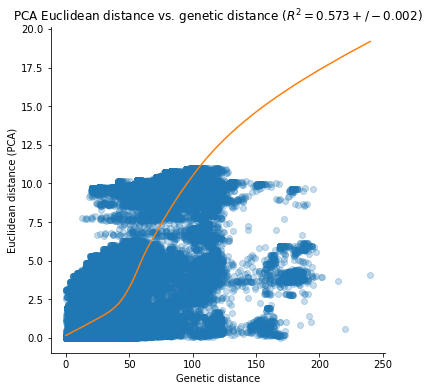

In [47]:
#total_df = pd.read_csv(snakemake.input.pca.replace(".csv", "") + "scatterplot.csv", index_col=0)
total_df_PCA = pd.read_csv("results/scatterplot_pca.csv",index_col=0)
metadata_PCA = pd.read_csv("results/scatterplot_pca_metadata.csv", index_col=0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title(f"PCA Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

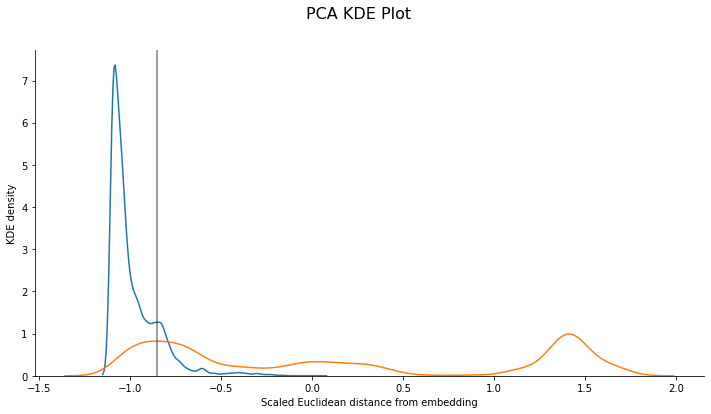

In [48]:
PCA_KDE_df = pd.read_csv("results/KDEDensity_pca.csv",index_col=0)
PCA_KDE_metadata_df = pd.read_csv("results/KDEDensity_pca_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=PCA_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('PCA KDE Plot', fontsize=16)
sns.despine()

# Running MDS on the Dataset

In [49]:
#principalDf = pd.read_csv(snakemake.input.pca)
MDS_df = pd.read_csv("results/embed_mds.csv",index_col=0)

In [50]:
merged_mds_df = MDS_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [51]:
merged_mds_df

strain      mds1       mds2      mds3      mds4  \
0    FrenchPolynesia2014_060114_016  4.129054  13.112623  1.741848 -2.724872   
1                         1_0049_PF  3.582383   7.384704 -0.112876 -2.196018   
2                         1_0030_PF  1.261029  11.225181  4.996538 -0.675158   
3                         1_0035_PF  2.211633  10.868029  7.278493 -2.109287   
4                         1_0087_PF  1.969932   9.287307  4.187647 -1.375823   
..                              ...       ...        ...       ...       ...   
669                  MEX/2016/mex45 -3.423036  -0.159996  0.160193 -1.105841   
670                         Bahia15  0.511999   0.660384 -0.046164 -0.123839   
671              NIC/5847_12B1/2016 -2.357302  -0.819468 -1.082556 -0.639712   
672                USA/2016/FLUR005 -1.447511   0.677582  1.426415 -3.560543   
673                USA/2016/FLUR001 -0.152552   0.995757  0.359230 -3.618828   

         mds5      mds6      mds7      mds8      mds9     mds10  mds_label  \
0    5.655200 -1.330113 -2.192388 -2.466294 -0.770108  3.271515         -1   
1    4.304568 -1.436197 -4.642009  1.189096 -2.221286  4.956264          6   
2    4.631858 -1.165978 -4.999114 -2.297133  1.101342  6.690295         -1   
3    6.843734 -1.345265 -4.202179 -2.735879 -1.369798  6.463743         -1   
4    4.755413 -1.549778 -2.671140 -1.947688 -0.220622  4.789161         -1   
..        ...       ...       ...       ...       ...       ...        ...   
669 -0.775239 -1.809334 -0.369571  0.405363  0.161886 -1.995334          6   
670  0.212477  0.603482  0.183375  0.207389 -0.041407  1.148536          6   
671 -0.904837 -2.995984 -2.677207  0.247250 -1.076854 -2.555581          6   
672 -1.804872  7.091327  4.249922  8.942806 -1.451194  1.554214          6   
673 -1.448885  5.180319  2.808425  8.284841 -2.085811  2.163111          6   

        date    y clade_membership clade_membership_color  
0    2014.02  153               c1                     c1  
1    2014.00  160               c1                     c1  
2    2013.83  129               c1                     c1  
3    2014.08  130               c1                     c1  
4    2013.97  133               c1                     c1  
..       ...  ...              ...                    ...  
669  2016.50  566               c4                     c4  
670  2016.00  179               c3                     c3  
671  2016.10  605               c4                     c4  
672  2016.58  310               c5                     c5  
673  2016.57  313               c5                     c5  

[674 rows x 16 columns]

In [52]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','clade_membership'],'clade_membership:N')
chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds3','mds4',"mds3","mds4",['strain','clade_membership'],'clade_membership_color')
chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds5','mds6',"mds5","mds6",['strain','clade_membership'],'clade_membership_color')
chart_12_mds|chart_34_mds|chart_56_mds

alt.HConcatChart(...)

In [53]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]

alt.HConcatChart(...)

# HDBSCAN output:

In [54]:
list_of_chart = linking_tree_with_plots_clickable(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'mds_label:N', ["mds_label"], ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

alt.HConcatChart(...)

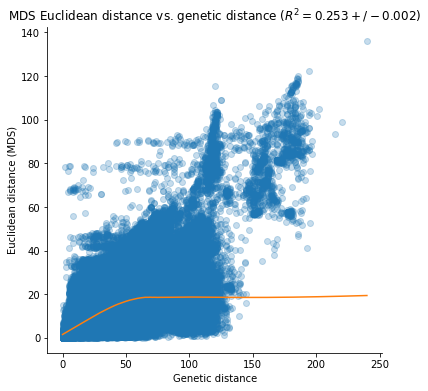

In [55]:
#total_df = pd.read_csv(snakemake.input.pca.replace(".csv", "") + "scatterplot.csv", index_col=0)
total_df_MDS = pd.read_csv("results/scatterplot_mds.csv",index_col=0)
metadata_MDS = pd.read_csv("results/scatterplot_mds_metadata.csv", index_col=0)

mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (MDS)")
ax.set_title(f"MDS Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()

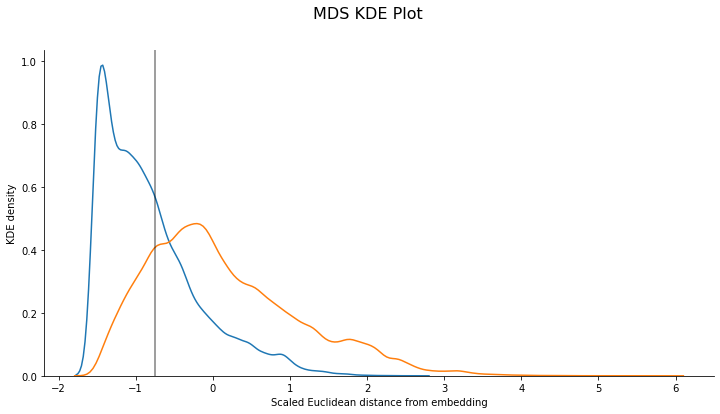

In [56]:
MDS_KDE_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_mds.csv",index_col=0)
MDS_KDE_metadata_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_mds_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=MDS_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('MDS KDE Plot', fontsize=16)
sns.despine()

# Running T-SNE on the Dataset 

In [57]:
#principalDf = pd.read_csv(snakemake.input.pca)
TSNE_df = pd.read_csv("results/embed_t-sne.csv",index_col=0)

In [58]:
TSNE_df

tsne_x     tsne_y  t-sne_label
strain                                                           
KX369547.1                       2.899385  -0.922875            4
FrenchPolynesia2014_060114_016   4.668188  -1.298287            4
1_0049_PF                        1.977217  -2.314795            4
1_0030_PF                        2.765864  -0.216481            4
1_0035_PF                        3.371844   0.047586            4
...                                   ...        ...          ...
MEX/2016/mex45                   9.969238 -10.439488            4
Bahia15                          4.134765  -3.655772            4
NIC/5847_12B1/2016               6.765837 -12.024717            4
USA/2016/FLUR005                16.452843  -2.738984            4
USA/2016/FLUR001                16.521885  -3.054027            4

[690 rows x 3 columns]

In [59]:
merged_tsne_df = TSNE_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [60]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership',
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

alt.HConcatChart(...)

# HDBSCAN Output

In [61]:
list_of_chart = linking_tree_with_plots_clickable(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    't-sne_label:N',
    ['t-sne_label'],
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

alt.HConcatChart(...)

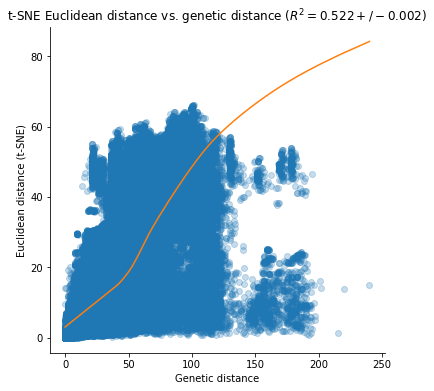

In [62]:
total_df_TSNE = pd.read_csv("results/scatterplot_t-sne.csv",index_col=0)
metadata_TSNE = pd.read_csv("results/scatterplot_t-sne_metadata.csv", index_col=0)

mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (t-SNE)")

ax.set_title(f"t-SNE Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")

sns.despine()
#plt.savefig("docs/TSNEScatterplot" + virus_name + ".png")

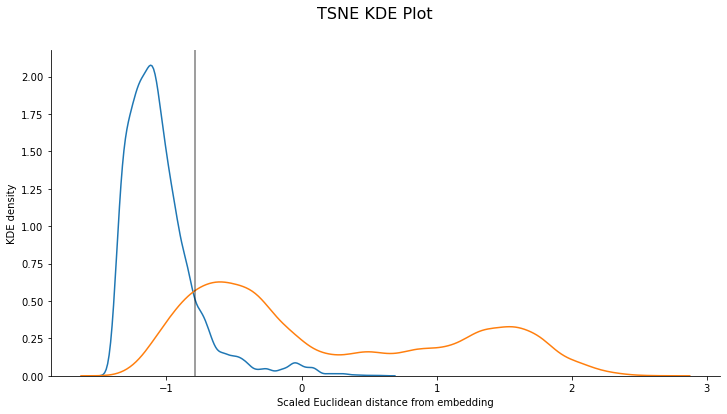

In [63]:
TSNE_KDE_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_t-sne.csv",index_col=0)
TSNE_KDE_metadata_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_t-sne_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=TSNE_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('TSNE KDE Plot', fontsize=16)
sns.despine()

# Running UMAP on the Dataset

In [64]:
#principalDf = pd.read_csv(snakemake.input.pca)
UMAP_df = pd.read_csv("results/embed_umap.csv",index_col=0)

In [65]:
merged_umap_df = UMAP_df.merge(node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]], on="strain")

In [66]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership',
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

alt.HConcatChart(...)

# HDBSCAN Output

In [67]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_clickable(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'umap_label:N',
    ['umap_label'],
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

alt.HConcatChart(...)

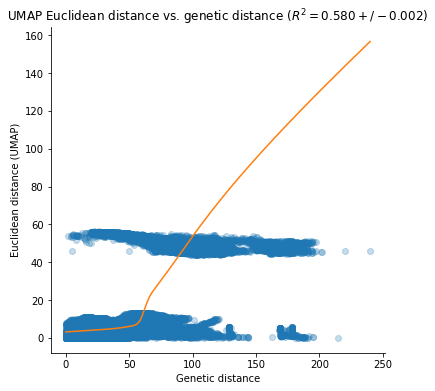

In [68]:
total_df_UMAP = pd.read_csv("results/scatterplot_umap.csv",index_col=0)
metadata_UMAP = pd.read_csv("results/scatterplot_umap_metadata.csv", index_col=0)

mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (UMAP)")

ax.set_title(f"UMAP Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")
sns.despine()
#plt.savefig("docs/UMAPScatterplot" + virus_name + ".png")

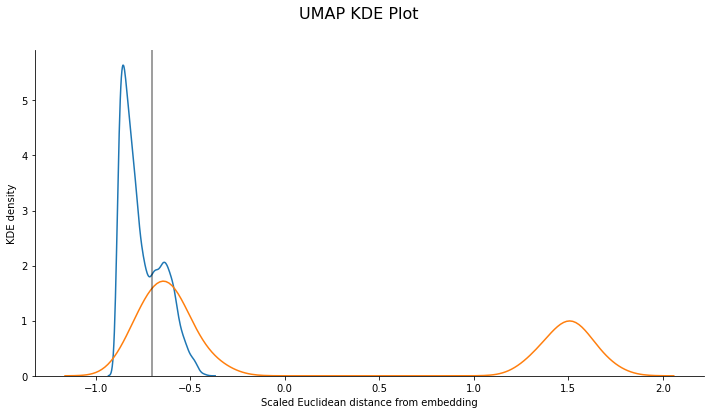

In [69]:
UMAP_KDE_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_umap.csv",index_col=0)
UMAP_KDE_metadata_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_umap_metadata.csv", index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax)

ax.axvline(x=UMAP_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('UMAP KDE Plot', fontsize=16)
sns.despine()

# Linking all plots together clickable with Tree

In [70]:
merged_df = node_df[["strain", "date", "y", "clade_membership", "clade_membership_color"]].merge(
    principalDf,
    on="strain"
).merge(
    MDS_df,
    on="strain"
).merge(
    TSNE_df,
    on="strain"
).merge(
    UMAP_df,
    on="strain"
)

In [71]:
data = linking_tree_with_plots_clickable(
    merged_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership:N',
    ['clade_membership'],
    ['strain','clade_membership']
)

In [78]:
PCAMDS = data[3]|data[1]|data[5]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.hconcat(data[0],embeddings)
fullChart
fullChart.save("../docs/FullLinkedChartClickable" + "Zika" + ".html")
#fullChart.save("docs/FullLinkedChartClickable" + virus_name + ".svg", scale_factor=2.0)
#drawing = svg2rlg("docs/FullLinkedChartClickable" + virus_name + ".svg")
#renderPDF.drawToFile(drawing, "docs/FullLinkedChartClickable" + virus_name + ".pdf")

In [79]:
fullChart

alt.HConcatChart(...)

## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

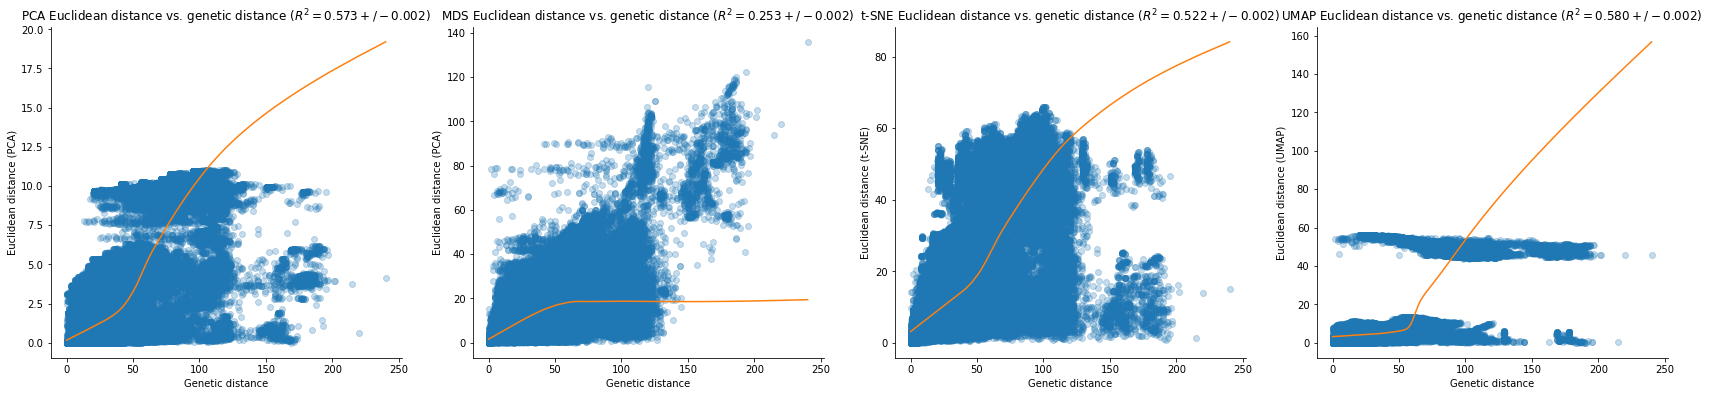

In [74]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.tight_layout(pad=4.0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title(f"PCA Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (PCA)")
ax2.set_title(f"MDS Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title(f"t-SNE Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")



mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title(f"UMAP Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


sns.despine()
plt.savefig("../docs/FullScatterplot" + "Zika" + ".png")

## Within- and between-clade Euclidean distances for all embeddings

Use the complete embedding data frame to calculate pairwise Euclidean distances between samples and plot the results in a single figure.

In [75]:
Genetic_KDE_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_genetic.csv",index_col=0)
Genetic_KDE_metadata_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_genetic_metadata.csv", index_col=0)

In [76]:
import matplotlib.gridspec as gridspec

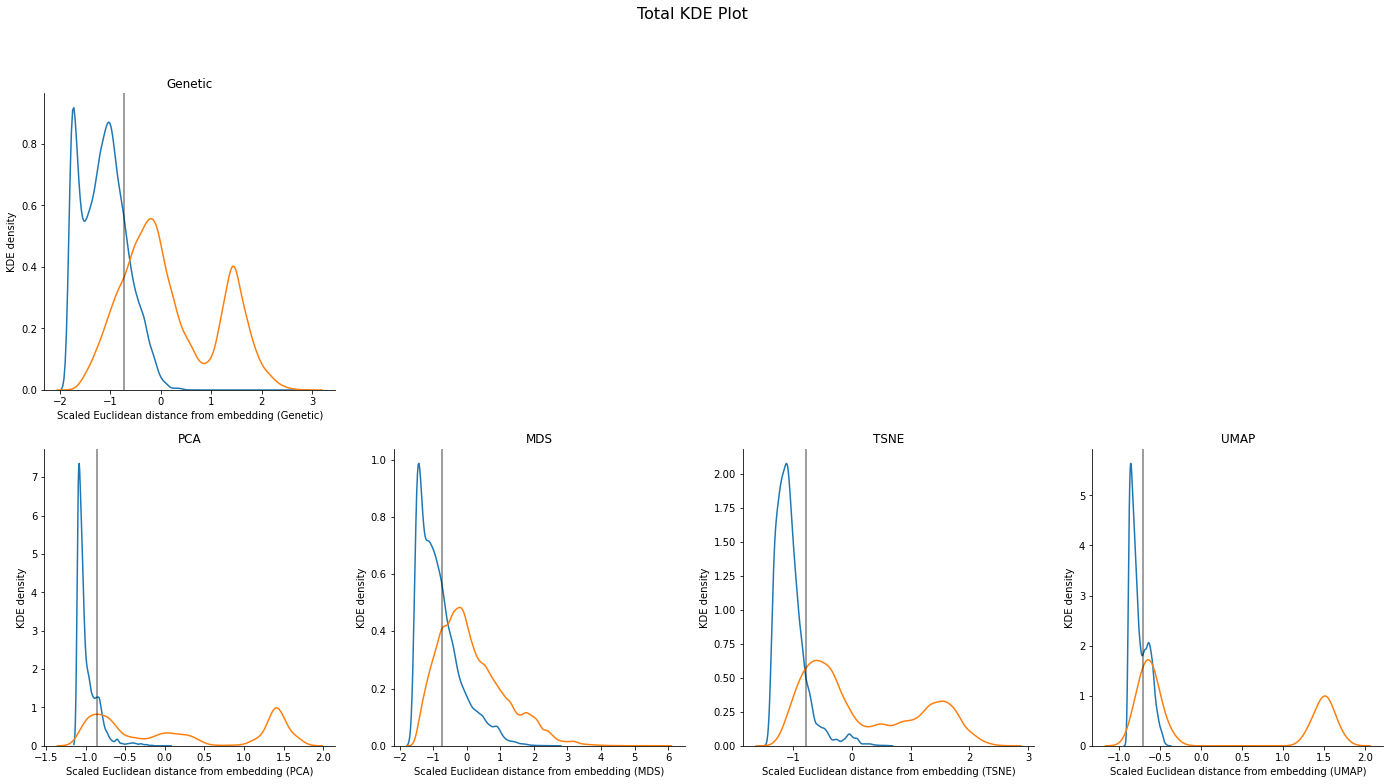

In [77]:
#fig, axes = plt.subplots(1, 5, figsize=(40, 8))
fig = plt.figure(figsize=(24, 12), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])
ax5 = fig.add_subplot(gs[1, 3])



#GENETIC 
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax1)
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax1)
ax1.axvline(x=Genetic_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax1.set_title('Genetic')
ax1.set_xlabel("Scaled Euclidean distance from embedding (Genetic)")
ax1.set_ylabel("KDE density")

#PCA
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax2)
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax2)
ax2.axvline(x=PCA_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax2.set_title('PCA')
ax2.set_xlabel("Scaled Euclidean distance from embedding (PCA)")
ax2.set_ylabel("KDE density")

#MDS
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax3)
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax3)
ax3.axvline(x=MDS_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax3.set_title('MDS')
ax3.set_xlabel("Scaled Euclidean distance from embedding (MDS)")
ax3.set_ylabel("KDE density")

#TSNE
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax4)
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax4)
ax4.axvline(x=TSNE_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax4.set_title('TSNE')
ax4.set_xlabel("Scaled Euclidean distance from embedding (TSNE)")
ax4.set_ylabel("KDE density")

#UMAP
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax5)
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax5)
ax5.axvline(x=UMAP_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax5.set_title('UMAP')
ax5.set_xlabel("Scaled Euclidean distance from embedding (UMAP)")
ax5.set_ylabel("KDE density")


fig.suptitle('Total KDE Plot', fontsize=16)
sns.despine()
plt.savefig("../docs/FullKDEDensity" + "Zika" + ".png")

# Supplemental Figures

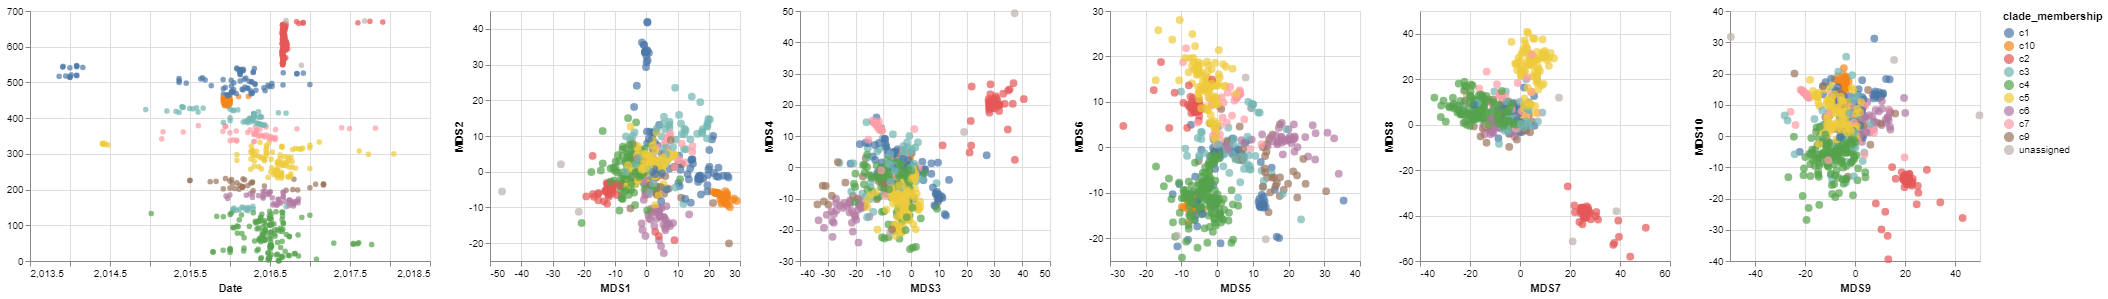

In [116]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds' + str(i) for i in range(1,11)],['MDS' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]

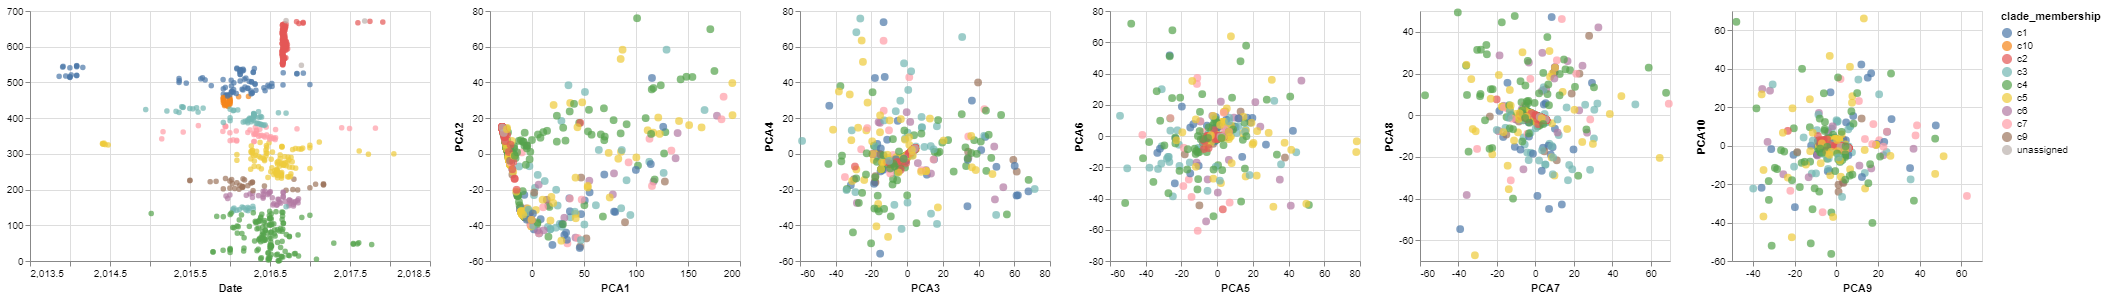

In [117]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca' + str(i) for i in range(1,11)],['PCA' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]